In [1]:
using Revise
using HypergraphNB
using DataFrames
using Clustering
using Statistics
using RCall
using Arpack
using Plots
using StatsBase
using SparseArrays
using Kronecker: ⊗
using LinearAlgebra
using SparseArrays

┌ Info: Precompiling HypergraphNB [2dbe4ab3-0c84-4f8d-86d2-f64d6d698dce]
└ @ Base loading.jl:1260
┌ Warning: Package HypergraphNB does not have StatsBase in its dependencies:
│ - If you have HypergraphNB checked out for development and have
│   added StatsBase as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HypergraphNB
└ Loading StatsBase into HypergraphNB from project dependency, future warnings for HypergraphNB are suppressed.


In [5]:
n  = 200
c₂ = 5
c₃ = 5
z  = 1 .+ (1:n .> n/2);

p₂ = 0.8
p₃ = 0.8

H = detectabilityData(n, c₂, c₃, p₂, p₃);

# Confirming Ihara-Bass Reduction

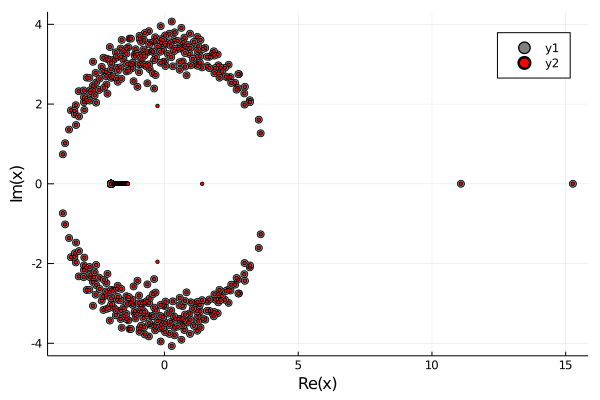

In [6]:
Bs, ix = nonBacktrackingMatrices(H);
B = sum(Bs);
E = Arpack.eigs(B; nev = 500, ritzvec = true);

B_ = reducedNonBacktrackingMatrix(H);

E_ = Arpack.eigs(B_; nev = 500, ritzvec = true);

plot(E[1], seriestype = :scatter, color = "grey")
plot!(E_[1], seriestype = :scatter, markersize = 2, color = "red")

In [7]:
@time E = Arpack.eigs(B; nev = 2, ritzvec = true);

@time E_ = Arpack.eigs(B_; nev = 2, ritzvec = true);

  0.007048 seconds (304 allocations: 932.047 KiB)
  0.001977 seconds (304 allocations: 348.297 KiB)


In [8]:
u = E[2][:,2]
E[1][2]
# plot(real.(u))

11.082489175800747 + 0.0im

In [9]:
M = length(ix)
length(u), M / n

(1999, 9.995)

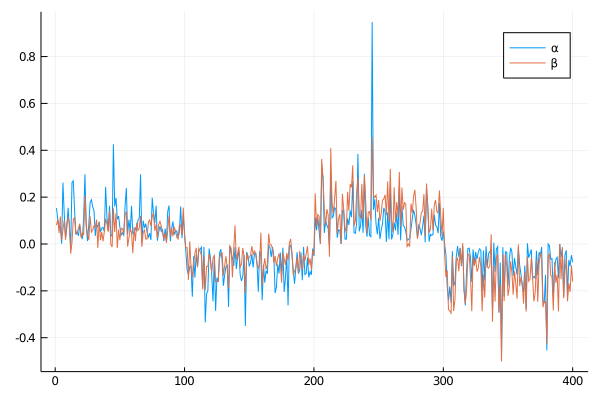

In [10]:
α = HypergraphNB.sumEigenvector(u, ix, "out")
β = HypergraphNB.sumEigenvector(u, ix, "in")
plot(real.(α), label = "α")
plot!(real.(β), label = "β")

# BP Jacobian Reduction: Scratchwork

First, let's compute the true spectrum of the BP Jacobian. This is the spectrum which we would like to reproduce in a reduced version of the matrix. 

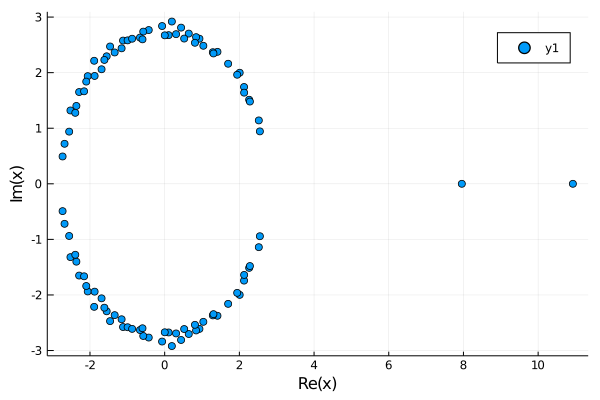

In [12]:
BP_mat, ix = BPJacobian(H, z);
E = Arpack.eigs(BP_mat; nev = 100, tol = 1e-10)
plot(E[1], seriestype = :scatter)
# plot!(xlim = (-1, 1), ylim = (-1, 1))

In [13]:
E[1][1:5]

5-element Array{Complex{Float64},1}:
  10.930392264366882 + 0.0im
   7.956700873253345 + 0.0im
 0.19191902781074205 + 2.9196124543725555im
 0.19191902781074205 - 2.9196124543725555im
 -1.8876256304284855 + 2.2138758712892197im

So, let's see if we can reproduce this. Fundamentally, all we need to do is construct a matrix of the correct dimensions and check its spectrum. 

# Construction of C matrices

There's a full block and a diagonal block matrix holding the entries of C, that I think we need to figure out here. There's one choice with which it's VERY close, but not there yet.  

In [14]:
K_ = sort(collect(keys(H.E)))
c, G = degreeTensor(H, z);
ẑ = z
q = 1/n * StatsBase.counts(ẑ)
G_ = zero(G)
for i ∈ 1:length(K_)
    G_[i,:,:] = (G[i,:,:] / ((K_[i] - 1) * c[i]) .- 1) .* q
end
ℓ = length(unique(ẑ))

2

### This one looks like it's almost there!! 

In [15]:
# with these choices it's not really close at all...

C = zeros(length(K_)*ℓ, length(K_)*ℓ)
dC = zeros(length(K_)*ℓ, length(K_)*ℓ)

for i ∈ 1:length(K_), j ∈ 1:length(K_), l ∈ 1:ℓ, h ∈ 1:ℓ
    C[l + ℓ*(j - 1), i + length(K_)*(h-1)] = G_[i, l, h]
    if i != j
        dC[l + ℓ*(j - 1), i + length(K_)*(h-1)] = G_[i, l, h]
    end
end

In [16]:
# with these it's REALLY close, but not sure why 
# it feels like these aren't indexed in the correct order, since k should 
# change more rapidly than ℓ in order to be consistent with the other matrices like D and A. 

Cs = [G_[i,:,:] for i ∈ 1:length(K_)]
dC = cat(Cs..., dims=(1,2))

C = hcat(Cs...)
C = vcat([C for i ∈ 1:length(K_)]...)

4×4 Array{Float64,2}:
  0.281186  -0.324131   0.390891  -0.373874
 -0.324131   0.367076  -0.373874   0.356857
  0.281186  -0.324131   0.390891  -0.373874
 -0.324131   0.367076  -0.373874   0.356857

In [17]:
# diagonal matrix of edge sizes
K = diagm(K_)

n = length(H.D)

# degree diagonal matrix

d = [HypergraphNB.degreeMatrix(H, k) for k ∈ K_]
D = cat(d..., dims = (1, 2))

# A = HypergraphNB.adjacencyBlockMatrix(H);

# adjacency matrix (diagonal)
a = [HypergraphNB.adjacencyMatrix(H, k) for k ∈ K_]
A = cat(a..., dims = (1, 2));

In [18]:
ℓ = length(unique(z))

# # upper-right block? 

upperRight = sparse(I(ℓ) ⊗ D) * sparse(C ⊗ I(n))   - sparse(dC ⊗ I(n))
size(upperRight) # correct dimensions

(800, 800)

In [19]:
# lower lefthand corner? 
lowerLeft = sparse((dC * (I(ℓ)⊗(I - K))) ⊗ I(n));
size(lowerLeft)

(800, 800)

In [20]:
lowerRight =  sparse(C ⊗ I(n)) * (I(ℓ) ⊗ A)   - (dC*(I(ℓ)⊗(K - 2I)))⊗I(n);
size(lowerRight)

(800, 800)

In [21]:
B_ = hcat(zero(upperRight), upperRight);
B_ = vcat(B_, hcat(lowerLeft, lowerRight));

In [22]:
E_ = Arpack.eigs(B_; nev = 100, tol = 1e-10);

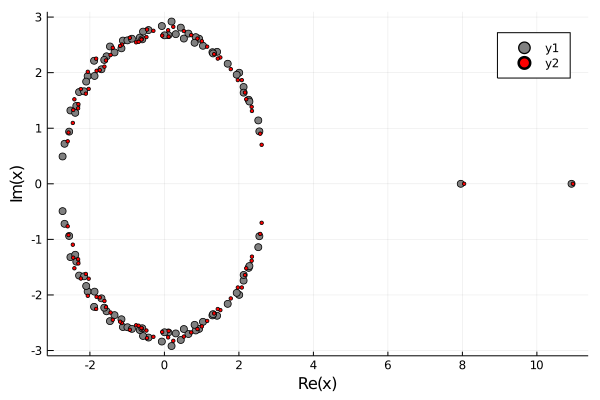

In [23]:
plot(E[1], seriestype = :scatter, color = "grey")
plot!(E_[1], seriestype = :scatter, markersize = 2, color = "red")

## A fresh attempt

In [24]:
K_ = sort(collect(keys(H.E)))
c, G = degreeTensor(H, z);
ẑ = z
q = 1/n * StatsBase.counts(ẑ)
G_ = zero(G)
for i ∈ 1:length(K_)
    G_[i,:,:] = (G[i,:,:] / ((K_[i] - 1) * c[i]) .- 1) .* q
end

In [25]:
C = zeros(length(K_)*ℓ, length(K_)*ℓ)
dC = zeros(length(K_)*ℓ, length(K_)*ℓ)

for i ∈ 1:length(K_), j ∈ 1:length(K_), l ∈ 1:ℓ, h ∈ 1:ℓ
    C[l + ℓ*(j - 1), i + length(K_)*(h-1)] = G_[i, l, h]
    if i != j
        dC[l + ℓ*(j - 1), i + length(K_)*(h-1)] = G_[i, l, h]
    end
end

In [26]:
ℓ = length(unique(z))

# # upper-right block? 

upperRight = sparse(C ⊗ I(n)) * sparse(I(ℓ) ⊗ D) - sparse(dC ⊗ I(n))
lowerLeft  = sparse((dC * (I(ℓ)⊗(I - K))) ⊗ I(n));
lowerRight = sparse(C ⊗ I(n)) * (I(ℓ) ⊗ A)   - (dC*(I(ℓ)⊗(K - 2I)))⊗I(n);

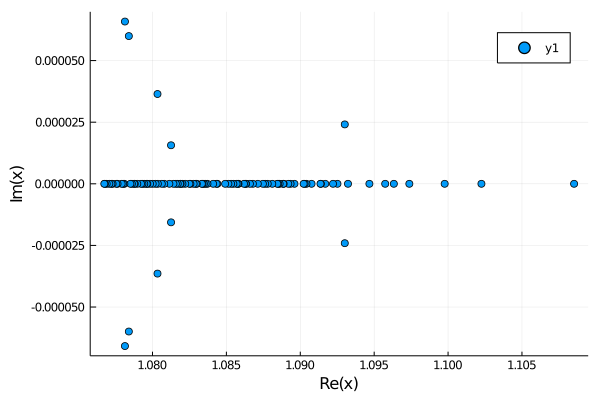

In [27]:
B_ = hcat(zero(upperRight), upperRight);
B_ = vcat(B_, hcat(lowerLeft, lowerRight));
E_ = Arpack.eigs(B_; nev = 100, tol = 1e-10);
plot(E_[1], seriestype = :scatter)

## Checking Eigenvectors...

In [28]:
u = E[2][:,2]
# size(u)
M = length(ix)
# ix
v₁ = real.(aggregateEigenvector(u[1:M], ix))
v₂ = real.(aggregateEigenvector(u[(M+1):2M], ix));

v = vcat(v₁, v₂)

λ = real.(E[1][2])

7.956700873253345

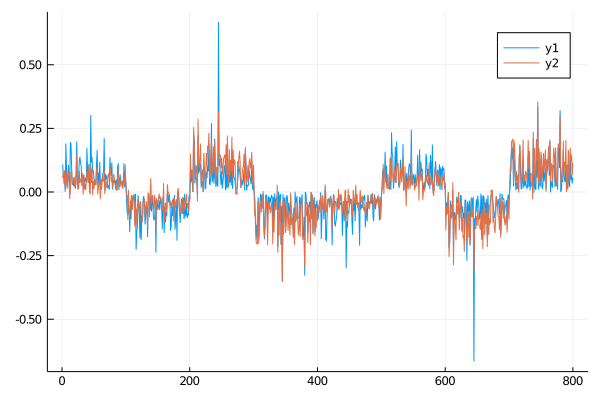

In [29]:
α = HypergraphNB.sumEigenvector(u, ix,  "out");
β = HypergraphNB.sumEigenvector(u, ix,  "in");

plot(real.(α))
plot!(real.(β))

In [30]:
v = vcat(α, β)
B_ * v ./ v 

1600-element Array{Float64,1}:
  6.142510460034017
  6.253683414487613
 10.913374746593874
  6.447041765912834
 15.91340174650673
  9.111990916405944
 14.965669637457925
 12.107459616897964
  9.7139983819176
  5.3796618765936435
  7.419515210376539
  6.745832313448055
  9.095483506156093
  ⋮
  8.576470555651031
 Inf
  9.772098998684713
 15.574818285653997
  9.079058706635209
  9.826243599957472
  8.294266005328284
  8.757914891313462
  7.721728977313381
  8.11510441026799
  8.847257860262909
  8.105515884656654